In [34]:
# #This provides access to data and to helper functions from previous weeks
# import lucem_illud #pip install git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk import ngrams, bigrams
# import docx

import pdfminer.pdfinterp
import pdfminer.converter
import pdfminer.layout
import pdfminer.pdfpage

import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import matplotlib.pyplot as plt #For graphics

import re 
import urllib.parse
import io 
import json 
import os.path 
import os 
import time
pd.set_option('max_colwidth',110)
%matplotlib inline


import plotly.plotly as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


def bar_chart(labels, values, title='', xaxis = '', yaxis = '', xsize = 14, subtitle=''):
    d = [go.Bar(
            x=labels,
            y=values,
            text=values,
            textposition = 'outside',
            opacity=1)]

    layout = go.Layout(
        title='<b>'+title+'</b><br>'+subtitle,
        xaxis=dict(
            title=xaxis,
            tickfont=dict(
                size=xsize,
                color='rgb(107, 107, 107)'
            )
        ),
        yaxis=dict(
            title=yaxis,
            titlefont=dict(
                size=16,
                color='rgb(107, 107, 107)'
            ),
            tickfont=dict(
                size=14,
                color='rgb(107, 107, 107)'
            )
        ),
    )

    fig = go.Figure(data=d, layout=layout)
    iplot(fig, filename='color-bar')
    

def viz(groupby_df, title = '', xaxis = '', yaxis = '', xsize = 14, subtitle=''):
    labels = list(groupby_df.index)
    values = list(groupby_df.values)
    
    d = [go.Bar(
            x=labels,
            y=values,
            text=values,
            textposition = 'outside',
            opacity=1)]

    layout = go.Layout(
        title='<b>'+title+'</b><br>'+subtitle,
        xaxis=dict(
            title=xaxis,
            tickfont=dict(
                size=xsize,
                color='rgb(107, 107, 107)'
            )
        ),
        yaxis=dict(
            title=yaxis,
            titlefont=dict(
                size=16,
                color='rgb(107, 107, 107)'
            ),
            tickfont=dict(
                size=14,
                color='rgb(107, 107, 107)'
            )
        ),
    )

    fig = go.Figure(data=d, layout=layout)
    iplot(fig, filename='color-bar')

In [5]:
stop_words_nltk = stopwords.words('english')
#stop_words = ["the","it","she","he", "a"] #Uncomment this line if you want to use your own list of stopwords.

#The stemmers and lemmers need to be initialized before bing run
porter = nltk.stem.porter.PorterStemmer()
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
        
    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)
    
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

In [6]:
path = 'C:/Users/vanguiano/Desktop/CoCWebsite/chiscrape/data/'
data = pd.read_csv(path+'data_output_2_6_1_14_cleaned.csv', encoding = 'iso-8859-1', index_col = 0)

In [7]:
data = data.fillna('None')

In [8]:
webpages = data[(data['description_words'] != 'No text found') & (data['description_words'] != '')].reset_index(drop = True)
print(len(webpages))
webpages = data

4082


In [9]:
stripped_rows = []
for row in webpages['description_words']:
    words = row.split(';')
    stripped_words = []
    for word in words:
        stripped_words.append(word.strip())
    stripped_rows.append(stripped_words)
webpages['normalized_tokens'] = stripped_rows

In [10]:
webpages['stemmatized_tokens'] = webpages['normalized_tokens'].apply(lambda x: normlizeTokens(x, stemmer = snowball, lemmer = wordnet))

In [11]:
webpages['normalized_tokens_POS'] = [nltk.pos_tag(w) for w in webpages['normalized_tokens']]

In [12]:
webpages['stemmatized_tokens_POS'] = [nltk.pos_tag(w) for w in webpages['stemmatized_tokens']]

In [13]:
def most_frequent_pos(tagged_words, pos, num):
    POS = nltk.ConditionalFreqDist((p, w) for w, p in tagged_words)
    return POS[pos].most_common(5)
webpages['most_frequent_verb'] = webpages['normalized_tokens_POS'].apply(lambda x: most_frequent_pos(x, 'VB', 10))
webpages['most_frequent_present_tense_verb'] = webpages['normalized_tokens_POS'].apply(lambda x: most_frequent_pos(x, 'VBP', 10))
webpages['most_frequent_past_tense_verb'] = webpages['normalized_tokens_POS'].apply(lambda x: most_frequent_pos(x, 'VBD', 10))
webpages['most_frequent_noun'] = webpages['normalized_tokens_POS'].apply(lambda x: most_frequent_pos(x, 'NN', 10))

In [14]:
def clean_title(title):
    if 'City of Chicago :: ' in title:
        return title[19:]
    return title
webpages['title'] = webpages['title'].apply(clean_title)

In [15]:
webpages.columns

Index(['dept', 'title', 'url', 'button', 'i_want_to', 'nav',
       'num_email_addresses', 'email_addresses', 'pdf_count', 'pdf_urls',
       'ext_link_count', 'ext_links', 'outside_domain', 'description_words',
       'services', 'dept_name', 'normalized_tokens', 'stemmatized_tokens',
       'normalized_tokens_POS', 'stemmatized_tokens_POS', 'most_frequent_verb',
       'most_frequent_present_tense_verb', 'most_frequent_past_tense_verb',
       'most_frequent_noun'],
      dtype='object')

In [16]:
webpages = webpages[['dept_name','title', 'url', 'services','button', 'i_want_to', 'nav',
       'num_email_addresses', 'email_addresses', 'pdf_count', 'pdf_urls',
       'ext_link_count', 'ext_links', 'outside_domain', 'description_words', 'normalized_tokens', 'stemmatized_tokens',
       'normalized_tokens_POS', 'stemmatized_tokens_POS', 'most_frequent_verb',
       'most_frequent_present_tense_verb', 'most_frequent_past_tense_verb',
       'most_frequent_noun']]

In [ ]:
webpages.to_csv('data/content_analysis_data.csv', sep = '`')

In [19]:
webpages_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in webpages['normalized_tokens_POS'].sum())

In [20]:
webpages_S_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in webpages['stemmatized_tokens_POS'].sum())

In [21]:
webpages_S_POStoWord['VBP'].most_common(25)

[('make', 854),
 ('confer', 725),
 ('build', 643),
 ('need', 590),
 ('exist', 493),
 ('joc', 452),
 ('protect', 425),
 ('see', 421),
 ('follow', 413),
 ('find', 365),
 ('hear', 312),
 ('avenu', 281),
 ('amend', 268),
 ('know', 266),
 ('offer', 259),
 ('ave', 218),
 ('intend', 216),
 ('collect', 215),
 ('learn', 213),
 ('go', 208),
 ('maintain', 208),
 ('take', 207),
 ('train', 204),
 ('hold', 192),
 ('use', 188)]

In [22]:
def group_by_dept(data, dept, stemmatized = False):
    data = data[data.dept_name == dept]
    if stemmatized == False:
        POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in data['normalized_tokens_POS'].sum())
    else:
        POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in data['stemmatized_tokens_POS'].sum())
    return POStoWord

In [23]:
%time by_dept = {}
for dept in webpages.dept_name.unique():
    by_dept[dept] = group_by_dept(webpages, dept, False)

Wall time: 0 ns


In [26]:
dept_verbs = {}
for dept in webpages.dept_name.unique():
        dept_verbs[dept] = by_dept[dept]['VB'].most_common(15)

In [48]:
def spli(dept):
    v = [y for x,y in dept_verbs[dept]]
    l = [x for x,y in dept_verbs[dept]]
    return bar_chart(l,v,'Verbs for '+ str(dept))
for dept in dept_verbs:
    spli(dept)

## Word Clouds

In [163]:
verbs = [t[0] for t in webpages['stemmatized_tokens_POS'].sum() if t[1].startswith('VBP')]

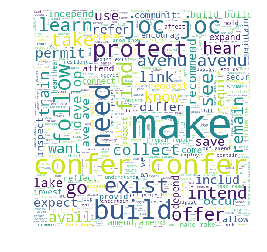

In [164]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(verbs))
plt.imshow(wc)
plt.axis("off")
plt.savefig("verbs_present.png", format = 'png')

In [158]:
def make_word_cloud(words, dept, pos, path):
    filename = dept + '_' + pos
    wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(words))
    plt.imshow(wc)
    plt.axis("off")
    plt.savefig(path + 'NORM_' + filename + ".png", format = 'png')

In [159]:
def select_words_given_pos(pos, tagged_words):
    words = [t[0] for t in tagged_words if t[1].startswith(pos)]
    return words

In [160]:
def tagged_words_by_dept(dept, data):
    tagged_words = data['normalized_tokens_POS'][data.dept_name == dept].sum()
    return tagged_words

In [161]:
def word_clouds_for_pos(pos, data, path):
    for dept in data.dept_name.unique():
        tagged_words = tagged_words_by_dept(dept, data)
        words_pos_chosen = select_words_given_pos(pos, tagged_words)
        if words_pos_chosen:
            make_word_cloud(words_pos_chosen, dept, pos, path)

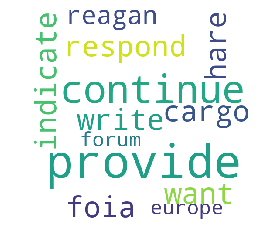

In [162]:
word_clouds_for_pos('VBP', webpages, 'word_clouds/')

## MISC

In [101]:
grams = list(bigrams(webpages['normalized_tokens'].sum()))

In [44]:
webpages[webpages['normalized_tokens'].apply(lambda x: 'visit' in x)]

,dept,title,url,button,i_want_to,nav,num_email_addresses,email_addresses,pdf_count,pdf_urls,...,ext_links,outside_domain,description_words,services,dept_name,normalized_tokens,stemmatized_tokens,normalized_tokens_POS,stemmatized_tokens_POS,most_frequent_present
0,oem,Report Suspicious Activity,https://www.cityofchicago.org/city/en/depts/oem/supp_info/report-suspicious-activity.html,False,True,True,0,,1,https://www.cityofchicago.org/content/dam/city/depts/oemc/supp_info/SeeSomethingSaySomething.pdf,...,http://www.dhs.gov/see-something-say-something,dhs.gov,see; something; say; something; report; suspicious; activitywe; play; role; keeping; communities; safe; se...,False,Emergency Management & Communications,"[see, something, say, something, report, suspicious, activitywe, play, role, keeping, communities, safe, s...","[see, someth, say, someth, report, suspici, activityw, play, role, keep, communiti, safe, see, someth, say...","[(see, VB), (something, NN), (say, VBP), (something, NN), (report, NN), (suspicious, JJ), (activitywe, JJ)...","[(see, VB), (someth, NNS), (say, VB), (someth, JJ), (report, NN), (suspici, NN), (activityw, JJ), (play, N...","[(say, 4), (see, 2), (terrorism, 1), (find, 1), (link, 1)]"
1,mayor,Hurricane and Earthquake Disaster Relief,https://www.cityofchicago.org/city/en/depts/mayor/supp_info/harvey-disaster-relief.html,False,True,True,1,mailto:maria1@prfaa.pr.gov,0,,...,http://www.chicagosistercities.com/; http://www.mayorscaucus.org/; http://www.worldbusinesschicago.com/; h...,ifrc.org; topos.mx; puertoricanchicago.org; houstonrecovers.org; projectpaz.org; safeandwell.communityos.o...,wake; hurricanes; harvey; irma; maria; recent; earthquakes; mexico; thoughts; victims; families; affected;...,False,Office of the Mayor,"[wake, hurricanes, harvey, irma, maria, recent, earthquakes, mexico, thoughts, victims, families, affected...","[wake, hurrican, harvey, irma, maria, recent, earthquak, mexico, thought, victim, famili, affect, natur, d...","[(wake, NN), (hurricanes, NNS), (harvey, VBP), (irma, JJ), (maria, FW), (recent, JJ), (earthquakes, NNS), ...","[(wake, NN), (hurrican, JJ), (harvey, NN), (irma, NN), (maria, FW), (recent, JJ), (earthquak, NN), (mexico...","[(puerto, 5), (donate, 3), (mexico, 2), (rico, 2), (welcome, 2)]"
23,dps,Current Bid Opportunities,https://www.cityofchicago.org/city/en/depts/dps/provdrs/contract/svcs/current_bid_opportunities.html,False,True,True,0,,133,https://www.cityofchicago.org/content/dam/city/depts/dps/ContractAdministration/Specs/2018/Spec579313.pdf;...,...,https://webapps1.cityofchicago.org/EDSWeb/appmanager/OnlineEDS/desktop; http://author.cityofchicago.org/co...,webapps1.cityofchicago.org; author.cityofchicago.org,eprocurement; bid; opportunities; solicitations; require; online; response; available; online; available; ...,True,Department of Procurement Services,"[eprocurement, bid, opportunities, solicitations, require, online, response, available, online, available,...","[eprocur, bid, opportun, solicit, requir, onlin, respons, avail, onlin, avail, pick, bid, bond, room, woul...","[(eprocurement, JJ), (bid, NN), (opportunities, NNS), (solicitations, NNS), (require, VBP), (online, JJ), ...","[(eprocur, JJ), (bid, NN), (opportun, NN), (solicit, NN), (requir, NN), (onlin, NN), (respons, NNS), (avai...","[(o'hare, 6), (rfq, 4), (architecture, 2), (require, 1), (addenda, 1)]"
27,cdph,Free STI/HIV Testing and STI Treatment,https://www.cityofchicago.org/city/en/depts/cdph/provdrs/health_services/svcs/get_yourself_evaluatedforsti...,False,True,True,0,,3,https://www.cityofchicago.org/content/dam/city/depts/cdph/tobacco_alchohol_and_drug_abuse/2016ChicagoOpioi...,...,https://visitor.r20.constantcontact.com/manage/optin/ea?v=001jsw_pnV76tUmSNJOdEkYeA%253D%253D; http://www....,cookcountyclerk.com; stopzikachicago.org; idph.state.il.us; hrsa.gov; who.int; gettestedchicago.com; visit...,cdph; lakeview; sti; clinic; closed; tuesday; february; resume; service; wednesday; february; effe

In [64]:
webpages[(webpages.dept_name == 'Department of Business Affairs and Consumer Protection') & (webpages.button == True)].sort_values(by='title')

,dept,title,url,button,i_want_to,nav,num_email_addresses,email_addresses,pdf_count,pdf_urls,...,ext_links,outside_domain,description_words,services,dept_name,normalized_tokens,stemmatized_tokens,normalized_tokens_POS,stemmatized_tokens_POS,most_frequent_present
24,bacp,Business License Look-up,https://www.cityofchicago.org/city/en/depts/bacp/provdrs/bus/svcs/business_licenselook-up.html,True,True,True,0,,1,https://www.cityofchicago.org/content/dam/city/depts/bacp/general/flyerdataportal20150325.pdf,...,https://data.cityofchicago.org/Community-Economic-Development/Business-Licenses-Current-Active/uupf-x98q,data.cityofchicago.org,interactive; website; allows; users; search; businesses; area; current; business; license; users; search; ...,True,Department of Business Affairs and Consumer Protection,"[interactive, website, allows, users, search, businesses, area, current, business, license, users, search,...","[interact, websit, allow, user, search, busi, area, current, busi, licens, user, search, address, busi, na...","[(interactive, JJ), (website, NN), (allows, VBZ), (users, NNS), (search, VBP), (businesses, NNS), (area, N...","[(interact, JJ), (websit, NN), (allow, IN), (user, JJ), (search, NN), (busi, IN), (area, NN), (current, JJ...","[(search, 2)]"
31,bacp,Business License Renewal,https://www.cityofchicago.org/city/en/depts/bacp/provdrs/bus/svcs/renew_your_businesslicenseonline.html,True,True,True,0,,1,https://www.cityofchicago.org/content/dam/city/depts/bacp/onlinerenewal/SampleOnlineBusinessLicenseRenewal...,...,https://webapps1.cityofchicago.org/LicenseRenewalWeb/home.do,webapps1.cityofchicago.org,online; license; weighing; measuring; device; renewal; system; use; online; application; renew; business; ...,True,Department of Business Affairs and Consumer Protection,"[online, license, weighing, measuring, device, renewal, system, use, online, application, renew, business,...","[onlin, licens, weigh, measur, devic, renew, system, use, onlin, applic, renew, busi, licens, weigh, measu...","[(online, JJ), (license, NN), (weighing, VBG), (measuring, VBG), (device, NN), (renewal, NN), (system, NN)...","[(onlin, NN), (licens, VBZ), (weigh, JJ), (measur, NN), (devic, VB), (renew, NN), (system, NN), (use, VBP)...","[(need, 2), (use, 1), (keep, 1), (contact, 1), (make, 1)]"
5,bacp,Business Licenses,https://www.cityofchicago.org/city/en/depts/bacp/provdrs/bus/svcs/apply_for_a_businesslicenseonline.html,True,True,True,0,,0,,...,https://webapps1.cityofchicago.org/IRISWeb/login.jsp,webapps1.cityofchicago.org,small; business; center; sbc; issues; business; licenses; regulates; business; activities; industries; div...,True,Department of Business Affairs and Consumer Protection,"[small, business, center, sbc, issues, business, licenses, regulates, business, activities, industries, di...","[small, busi, center, sbc, issu, busi, licens, regul, busi, activ, industri, diver, retail, food, liquor, ...","[(small, JJ), (business, NN), (center, NN), (sbc, NN), (issues, NNS), (business, NN), (licenses, VBZ), (re...","[(small, JJ), (busi, NN), (center, NN), (sbc, NN), (issu, NN), (busi, NN), (licens, VBZ), (regul, JJ), (bu...","[(diverse, 1), (go, 1), (click, 1)]"
47,bacp,Cab Feedback,https://www.cityofchicago.org/city/en/depts/bacp/provdrs/consumer/svcs/consumer_cab_complaint.html,True,True,True,0,,0,,...,https://servicerequest.cityofchicago.org/web_intake_chic/Controller?op=locform&invSRType=CSC&invSRDesc=Cab...,servicerequest.cityofchicago.org,service; request; used; report; problems; taxicab; related; problems; complaints; investigated; condition;...,True,Department of Business Affairs and Consumer Protection,"[service, request, used, report, problems, taxicab, related, problems, complaints, investigated, condition...","[servic, request, use, report, problem, taxicab, relat, problem, complaint, investig, condit, safeti, cab,...","[(service, NN), (request, NN), (used, VBN), (report, NN), (problems, NNS), (taxicab, VBP), (related, VBN),...","[(servi

In [50]:
data.groupby('dept_name').size().sort_values(ascending=False)

dept_name
None                                                      1585
Department of Cultural Affairs and Special Events          600
Department of Planning and Development                     546
Department of Finance                                      311
Department of Procurement Services                         299
Department of Business Affairs and Consumer Protection     294
Department of Public Health                                288
Department of Family & Support Services                    198
Department of Transportation                               196
Office of the Mayor                                        186
Department of Buildings                                    175
Department of Law                                          161
Department of Streets and Sanitation                       158
Department of Water Management                             149
Board of Ethics                                            137
Department of Human Resources                